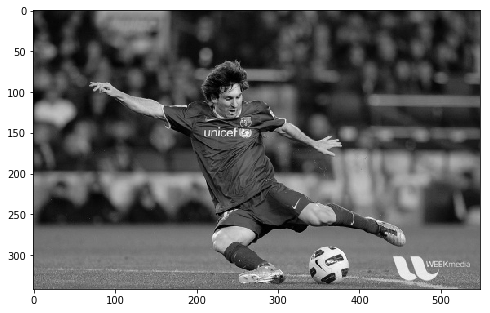

In [137]:
항

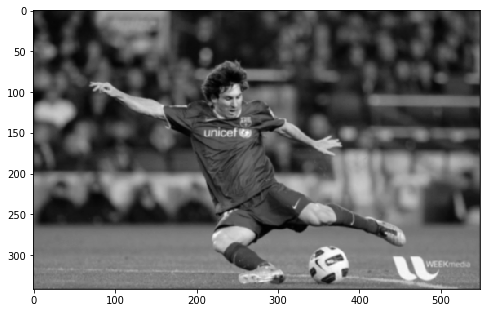

In [129]:
plt.figure(figsize=(8,12))
img_blur = gaussian_filtering(img,k_size=5, sigma=0.8)
plt.imshow(img_blur,cmap="gray")

In [130]:
"""
ref
- https://en.wikipedia.org/wiki/Canny_edge_detector
"""
def sobel_kerenl():
    kernel_x = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    kernel_y = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])
    return kernel_x, kernel_y

def get_rounded_gradient_angle(ang):
    """
    get_rounded_gradient_angle
    - gradient direction angle round to one of four angles
    
    return : one of four angles
            representing vertical, horizontal and two diagonal direction
    
    parameteres
    ---------------
    ang : gradient direction angle
    """
    vals = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4, np.pi*4/4]
    interval = [np.pi*1/8, np.pi*3/8, np.pi * 5/8, np.pi* 7/8]

    if ang < interval[0] and ang >= interval[-1]:
        ang = vals[0]
    elif ang < interval[1] and ang >= interval[0]:
        ang = vals[1]
    elif ang < interval[2] and ang >= interval[1]:
        ang = vals[2]
    elif ang < interval[3] and ang >= interval[2]:
        ang = vals[3]
    else:
        ang = vals[4]
    return ang
        

def get_gradient_intensity(img):
    """
    get gradient_intensity
    - calculate gradient direction and magnitude
    
    return (rows, cols, 2) shape of image about grad direction and mag
    
    parameteres
    ------------
    img : blured image
    """
    k_size = 3
    rows, cols = img.shape
    kernel_x, kernel_y = sobel_kerenl()
    pad_img = padding(img, k_size=k_size)
    res = np.zeros((rows, cols, 2))
    sx, sy = 0, 0

    for i in range(0, rows):
        for j in range(0, cols):
            boundary = pad_img[i:i+k_size, j:j+k_size]
            sx = np.sum(kernel_x * boundary)
            sy = np.sum(kernel_y * boundary)            
            ang = np.arctan2(sy, sx)
            mag = abs(sx) + abs(sy)
            if ang < 0:
                ang = ang + np.pi
            ang = get_rounded_gradient_angle(ang)
            res[i, j, 0] = ang
            res[i, j, 1] = mag
    return res

In [131]:
grad_intensity = get_gradient_intensity(img_blur)

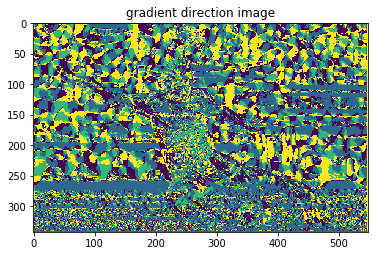

In [132]:
plt.title("gradient direction image")
plt.imshow(grad_intensity[:,:,0])

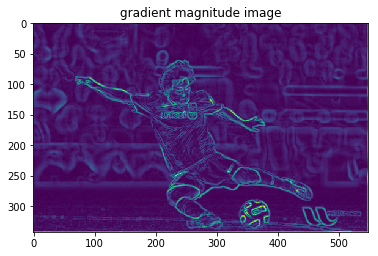

In [133]:
plt.title("gradient magnitude image")
plt.imshow(grad_intensity[:,:,1])

In [151]:

def check_local_maximum(direction=None, boundary=None):
    """
    check_local_maximum
    - check if center value is local maximum depend on gradient direction
    return True if center valus is local maximum
    
    parameter
    ------------
    direction : gradient direction
    boundary : region of image for finding local maximum
    """
    if direction == 0: # 0 degree, east and west direction
        kernel = np.array([
            [0, 0, 0],
            [1, 1, 1],
            [0, 0, 0]
        ])

    elif direction == 1: #45 degree, north east and south west direction
        kernel = np.array([
            [0, 0, 1],
            [0, 1, 0],
            [1, 0, 0]
        ])
    elif direction == 2: #90 degree, north & south direction
        kernel = np.array([
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0]
        ])
    else : #135 degree, north west & south east direction
        kernel = np.array([
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ])
    
    max_val = np.max(kernel * boundary)
    if boundary[1,1] == max_val: #local maximum
        return True
    else: # not local maximu
        return False

    
    
def non_maximum_suppression(grad_intensity=grad_intensity):
    """
    non_maximum_suppression
    - check a pixel wiht it's neighbors in the direction of gradient
    - if a pixel is not local maximum, it is suppressed(means to be zero)
    """
    directions = [0, np.pi*1/4, np.pi*2/4, np.pi*3/4, np.pi*4/4]
    
    k_size = 3
    grad_direction = grad_intensity[:, :, 0]
    grad_magnitude = grad_intensity[:, :, 1]
    
    rows, cols = grad_magnitude.shape
    pad_img = padding(grad_magnitude, k_size=k_size)
    res_img = np.zeros((rows,cols))
    sx, sy = 0, 0
    
    
    for i in range(0, rows):
        for j in range(0, cols):
            direction = directions.index(grad_direction[i,j])
            boundary = pad_img[i:i+k_size, j:j+k_size]
            if check_local_maximum(direction, boundary) == True:
                res_img[i, j] = grad_magnitude[i, j]
            else:
                res_img[i, j] = 0
    return res_img

In [152]:
supressed_img = non_maximum_suppression(grad_intensity)

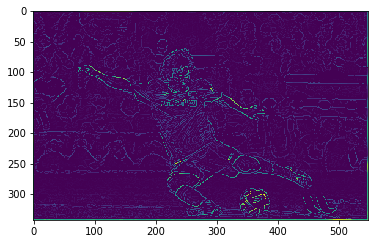

In [153]:
plt.imshow(supressed_img)

In [157]:
def canny_edge_detector_tmp(img=None, min_th=None, max_th=None):
    img_blur = gaussian_filtering(img,k_size=5, sigma=1)
    grad_intensity = get_gradient_intensity(img_blur)
    supressed_img = non_maximum_suppression(grad_intensity)
    
    k_size = 3
    rows, cols = supressed_img.shape
    pad_img = padding(supressed_img, k_size=k_size)
    res_img = np.zeros((rows,cols))
    sx, sy = 0, 0
    
    
    for i in range(0, rows):
        for j in range(0, cols):
            if pad_img[i+1, j+1] < min_th:
                res_img[i, j] = 0
            else:
                res_img[i, j] = pad_img[i+1, j+1]
            
    return res_img

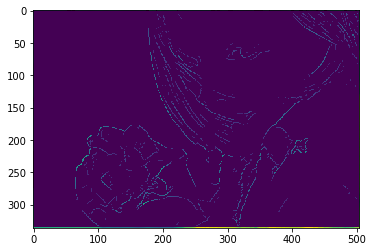

In [159]:
kid = Image.open("./res/kid.jpg").convert("L")
kid = np.asarray(kid)
kid = canny_edge_detector(img=kid, min_th=100, max_th=200)
plt.imshow(kid)

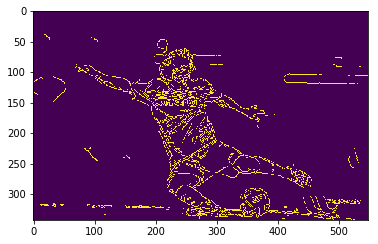

In [142]:
edges = cv2.Canny(img, 100, 200)
plt.imshow(edges)

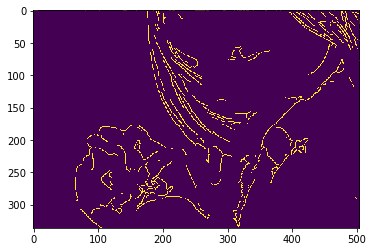

In [154]:
edges = cv2.Canny(kid, 100, 200)
plt.imshow(edges)

In [201]:
def hysteresis_threshold(suppressed_img=None, min_th=None, max_th=None):
    """
    hysterisis_threshold
    - check edge is connected to strong edge using eight connectivity
    
    parameter
    ---------------------
    - suppressed img : non maximum suppressed image
    - min_th : minimal threshold value
    - max_th : maximum threshold value
    """
    k_size = 3
    rows, cols = supressed_img.shape
    pad_img = padding(suppressed_img, k_size=k_size)
    res_img = np.zeros((rows,cols))

    eight_connectivity = np.array([
        [1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]
    ])    
    
    for i in range(0, rows):
        for j in range(0, cols):
            if pad_img[i+1, j+1] < min_th:
                res_img[i, j] = 0
            else:
                boundary = pad_img[i:i+k_size, j:j+k_size]
                max_magnitude = np.max(boundary * eight_connectivity)
                if max_magnitude >= max_th : # pixel is connected to real edge
                    res_img[i, j] = 255
                else:
                    res_img[i, j] = 0
    return res_img

def canny_edge_detector(img=None, min_th=None, max_th=None):
    """
    canny_edge_detector
    - detect canny edge from original image
    
    parameter
    - img : original image
    - min_th : minimal threshold value
    - max_th : maximum threshold value
    """
    img_blur = gaussian_filtering(img,k_size=5, sigma=1)
    grad_intensity = get_gradient_intensity(img_blur)
    suppressed_img = non_maximum_suppression(grad_intensity)
    canny_edge = hysteresis_threshold(suppressed_img=suppressed_img,
                                      min_th=min_th, max_th=max_th)
    return canny_edge

In [161]:
img_blur = gaussian_filtering(kid,k_size=5, sigma=0.8)
grad_intensity = get_gradient_intensity(img_blur)
supressed_img = non_maximum_suppression(grad_intensity)

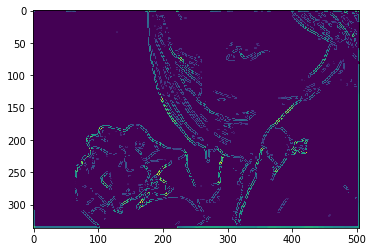

In [178]:
plt.imshow(supressed_img)

In [176]:
res = hysteresis_threshold(suppressed_img=supressed_img, min_th=100, max_th=200)

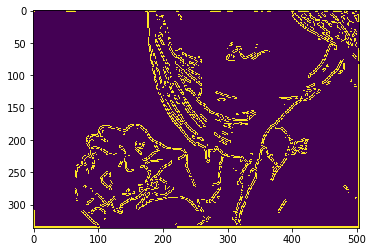

In [177]:
plt.imshow(res)

In [168]:
print(edges)

[[  0   0 255 ... 255   0   0]
 [255 255   0 ...   0 255 255]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]
 [  0   0   0 ...   0 255   0]]


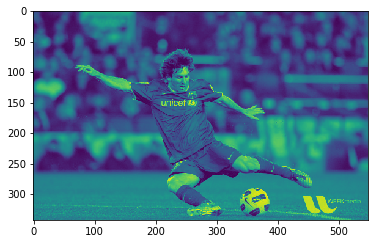

In [183]:
img = Image.open("./res/messi5.jpg").convert("L")
img = np.asarray(img)
plt.imshow(img)

In [202]:
img = Image.open("./res/messi5.jpg").convert("L")
img = np.asarray(img)
img_blur = gaussian_filtering(img,k_size=5, sigma=1)
grad_intensity = get_gradient_intensity(img_blur)
suppressed_img = non_maximum_suppression(grad_intensity)
canny_edge = hysteresis_threshold(suppressed_img=suppressed_img,min_th=100, max_th=200)

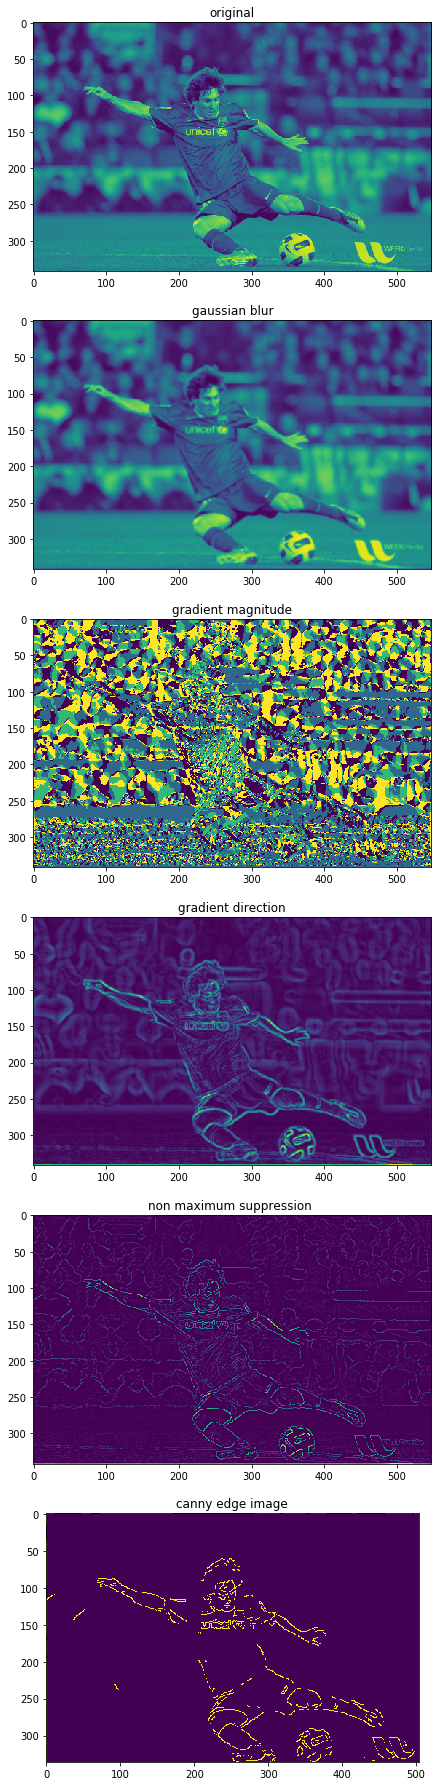

In [205]:
plt.figure(figsize=(64,32))
plt.subplot(6, 1, 1)
plt.title("original")
plt.imshow(img)
plt.subplot(6, 1, 2)
plt.title("gaussian blur")
plt.imshow(img_blur)
plt.subplot(6, 1, 3)
plt.title("gradient direction")
plt.imshow(grad_intensity[:, :,0])
plt.subplot(6, 1, 4)
plt.title("gradient magnitude")
plt.imshow(grad_intensity[:, :,1])
plt.subplot(6, 1, 5)
plt.title("non maximum suppression ")
plt.imshow(suppressed_img)
plt.subplot(6, 1, 6)
plt.title("canny edge image")
plt.imshow(canny_edge)

In [206]:
def canny_edge_visualize(img, min_th=100, max_th=200):
    """
    canny_edge_visualize
    - visualize all images from original to canny edge
    
    parameter
    - img : original image
    - min_th : minimal threshold value
    - max_th : maximum threshold value
    """
    img_blur = gaussian_filtering(img,k_size=5, sigma=1)
    grad_intensity = get_gradient_intensity(img_blur)
    suppressed_img = non_maximum_suppression(grad_intensity)
    canny_edge = hysteresis_threshold(suppressed_img=suppressed_img,min_th=100, max_th=200)

    plt.figure(figsize=(64,32))
    plt.subplot(6, 1, 1)
    plt.title("original")
    plt.imshow(img)
    plt.subplot(6, 1, 2)
    plt.title("gaussian blur")
    plt.imshow(img_blur)
    plt.subplot(6, 1, 3)
    plt.title("gradient magnitude")
    plt.imshow(grad_intensity[:, :,0])
    plt.subplot(6, 1, 4)
    plt.title("gradient direction")
    plt.imshow(grad_intensity[:, :,1])
    plt.subplot(6, 1, 5)
    plt.title("non maximum suppression ")
    plt.imshow(suppressed_img)
    plt.subplot(6, 1, 6)
    plt.title("canny edge image")
    plt.imshow(canny_edge)

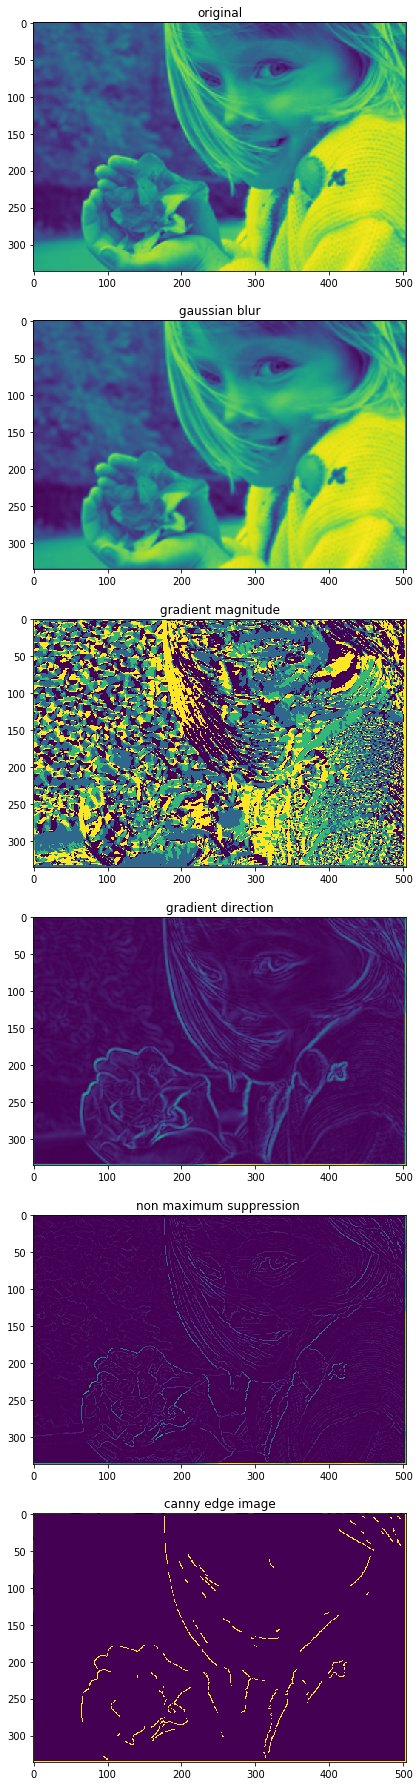

In [208]:
img = Image.open("./res/kid.jpg").convert("L")
img = np.asarray(img)
canny_edge_visualize(img)